In [1]:
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import nltk
from nltk.stem import SnowballStemmer # 提取词干
os.environ["export CUDA_VISIBLE_DEVICES"] = '0'

In [2]:
# 加载数据集
dataset = pd.read_csv("dataset/data/train.csv", engine="python")
dataset.head()

,review,label
0,你们这些大骗子，不是说不疼吗？[泪],0
1,色总，您是大明星啊 //@辞小西:噗哈哈哈哈哈哈！！！[哈哈]哎呀我去啊，色总那羞涩的眼神...,1
2,反正比喵总漂亮的第二天都得。。。[嘻嘻] //@冯绍峰:能低调点嘛[挖鼻屎],1
3,以后谁也不要请我喝可乐！我跟可乐犯冲。带狗出去没法进饭店就去KFC买了全家桶回家，还没到家三...,0
4,上次真应该囤点巧克力 听了你@chloe518 建议 中午火速买黑巧 希望下午暖和点吧 别...,0


In [3]:

dataset['label'].value_counts()

0    53995
1    53993
Name: label, dtype: int64

In [4]:
#停用词
stop_words =  [line.strip() for line in  open('dataset/dic/stop.txt','r').readlines()]
# 词干
# stemmer = SnowballStemmer('english')

In [5]:
# 对文本进行清洗
import re

def preprocessing(text, stem=False):
    tokens = []
    for token in text:
        if token not in stop_words:
            if stem:
                tokens.append(stemmer.stem(token)) # 提取词干
            else:
                tokens.append(token) # 直接保存单词
    return ' '.join(tokens)

In [6]:
dataset.review = dataset.review.apply(lambda x: preprocessing(x))

In [7]:
dataset.review[3]

'请 喝 乐 乐 犯 狗 法 进 饭 店 K F C 买 全 家 桶 回 家 家 杯 乐 洒 两 杯 车 里 害 纸 费 干 净 家 买 瓶 结 果 撒 家 里 杯 汗 晕 喝 乐 乐 噩 梦 衰 衰 衰 太'

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [7]:
train_dataset, test_dataset = train_test_split(dataset, test_size = 0.2, random_state = 666, shuffle=True)
train_dataset.shape

(86390, 2)

In [8]:
train_dataset.head()
test_dataset.head()

,review,label
28626,你会选哪个做礼物？反正是金的我都想要！[泪][泪][泪] #Lovegold爱礼物##想送我...,0
24470,今天在江西北部发现一红豆杉林，负离子比这差远了！//@天涯冰峰:那里今天中午的负氧离子值14...,1
102596,珍惜生命，别拿生命熬夜//@空客A380V: [悲伤]小伙伴们，珍惜生命，别拿生命熬夜了.....,0
50886,[哈哈]逗你玩,1
20402,我跟你们讲啊，无论你的身材再瘦，只要你有个大圆脸，那么你给别人第一印象就是个胖子…… [抓狂...,0


### 分词

In [10]:
# 分词
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_dataset.review)

In [11]:
# 每个单词对应一个索引
word_index = tokenizer.word_index
# 训练集词汇表大小
vocab_size = len(word_index) + 1
vocab_size

278046

### 固定每一条文本的长度

In [12]:
MAX_WORDS = 100000 # 最大词汇量10万
MAX_SEQ_LENGTH = 100 # 最大序列长度30
 
from tensorflow.keras.preprocessing.sequence import pad_sequences
x_train = pad_sequences(tokenizer.texts_to_sequences(train_dataset.review),
                        maxlen=MAX_SEQ_LENGTH)
x_test = pad_sequences(tokenizer.texts_to_sequences(test_dataset.review),
                       maxlen=MAX_SEQ_LENGTH)


In [14]:
x_train.shape
x_test.shape

(21598, 100)

In [14]:
# 标签类别进行LabelEncoding，将类别编码成连续的编号
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y_train = encoder.fit_transform(train_dataset.label.tolist())
y_test = encoder.fit_transform(test_dataset.label.tolist())



In [15]:
y_train = y_train.reshape(-1, 1) # shape 转置
y_train.shape

(86390, 1)

In [16]:
y_test = y_test.reshape(-1, 1)
y_test.shape

(21598, 1)

In [17]:
# word embedding 词嵌入 ： 将单词用特征向量来表示，这里使用预训练的词向量 GloVe

GloVe = "dataset/dic/glove.6B.300d.txt"
EMBEDDING_DIM = 300 # 300 维
BATCH_SIZE = 10000 # 批处理的大小
EPOCHS = 10 # 循环的次数
LR = 1e-3 # 学习率
MODEL_PATH = "dataset/models/best_model.hdf5" # 保存模型路径

In [18]:
# 构建字典： 格式： { 单词 ： 词嵌入向量}
embedding_index = {}
with open(GloVe) as f:
    for line in f:
        values = line.split() # 按空格分割
        word = values[0] # 第一个位置上是单词
        embeddings = np.asarray(values[1:], dtype="float32") # 每个单词对应的词嵌入
        embedding_index[word] = embeddings # 键值对

In [19]:
len(embedding_index) # 单词数

400000

In [21]:
# 获取词嵌入矩阵
embedding_matrix = np.zeros((vocab_size, EMBEDDING_DIM)) # vocab_size : 训练集词汇表大小，EMBEDDING_DIM : 词嵌入维度
num = 0
for word, values in embedding_index.items():
    embedding_vector = embedding_index.get(word) # 单词对应的词嵌入向量
    if embedding_vector is not None:
        if num < vocab_size:
            embedding_matrix[num, :] = embedding_vector
        num += 1

embedding_matrix.shape

(278046, 300)

### 模型搭建

In [33]:
from tensorflow.keras.layers import Conv1D, Bidirectional, LSTM, Dense, Input, Dropout, Embedding
from tensorflow.keras.layers import SpatialDropout1D # 丢弃整个1D的特征图而不是丢弃单个元素，提高特征图之间的独立性
from tensorflow.keras.callbacks import ModelCheckpoint

In [34]:
sequence_input = Input(shape=(MAX_SEQ_LENGTH, ), dtype='int32') # 设置输入序列长度 MAX_SEQ_LENGTH

In [35]:
embedding_layer = Embedding(vocab_size, # 词汇表大小
                            EMBEDDING_DIM, # 词嵌入维度
                            weights = [embedding_matrix], # 预训练词嵌入
                            input_length = MAX_SEQ_LENGTH, # 序列长度
                            trainable = False)

In [30]:
embedding_sequences = embedding_layer(sequence_input)

x = SpatialDropout1D(0.2)(embedding_sequences)
print(x.shape)
x = Conv1D(64, 5, activation='relu')(x)
print(x.shape)
x = Bidirectional(LSTM(64, dropout=0.2, recurrent_dropout=0.2))(x)
print(x.shape)
x = Dense(512, activation='relu')(x)
print(x.shape)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
print(x.shape)
outputs = Dense(1, activation='sigmoid')(x)
print(outputs.shape)
model = tf.keras.Model(sequence_input, outputs)

(None, 100, 300)
(None, 96, 64)
(None, 128)
(None, 512)
(None, 512)
(None, 1)


In [36]:
import tensorflow
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau

# 模型变异
model.compile(optimizer=Adam(learning_rate=LR), loss='binary_crossentropy', metrics=['accuracy'])
early_stopping = tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.1, patience=2, verbose=1)
model_checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(filepath='dataset/models/ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5',
                                                   monitor='val_loss',
                                                   verbose=1,
                                                   save_best_only=True,
                                                   save_weights_only=True,
                                                   period=1)
ReduceLR = ReduceLROnPlateau(factor=0.1, min_lr=0.01, monitor='val_loss', verbose=1)
# factor : 学习速率被降低的因数， 新的学习速率 = 学习率 * 因素
# min_lr : 学习率的下边界
# monitor : 被监测的数据

In [37]:
# 模型训练

history = model.fit(x_train, y_train, batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(x_test, y_test),
                    callbacks=[early_stopping, model_checkpoint, ReduceLR])

Epoch 1/10
9/9 [==============================] - ETA: 0s - loss: 0.6910 - accuracy: 0.5347
Epoch 00001: val_loss improved from inf to 0.64548, saving model to dataset/models/ep001-loss0.691-val_loss0.645.h5
9/9 [==============================] - 32s 4s/step - loss: 0.6910 - accuracy: 0.5347 - val_loss: 0.6455 - val_accuracy: 0.7768
Epoch 2/10
9/9 [==============================] - ETA: 0s - loss: 0.5700 - accuracy: 0.7164
Epoch 00002: val_loss improved from 0.64548 to 0.58800, saving model to dataset/models/ep002-loss0.570-val_loss0.588.h5
9/9 [==============================] - 31s 3s/step - loss: 0.5700 - accuracy: 0.7164 - val_loss: 0.5880 - val_accuracy: 0.7240
Epoch 3/10
9/9 [==============================] - ETA: 0s - loss: 0.4853 - accuracy: 0.7729
Epoch 00003: val_loss improved from 0.58800 to 0.37297, saving model to dataset/models/ep003-loss0.485-val_loss0.373.h5
9/9 [==============================] - 31s 3s/step - loss: 0.4853 - accuracy: 0.7729 - val_loss: 0.3730 - val_accu

### 获知训练和验证结果

accuary:0.9424946904182434


<Figure size 432x288 with 0 Axes>

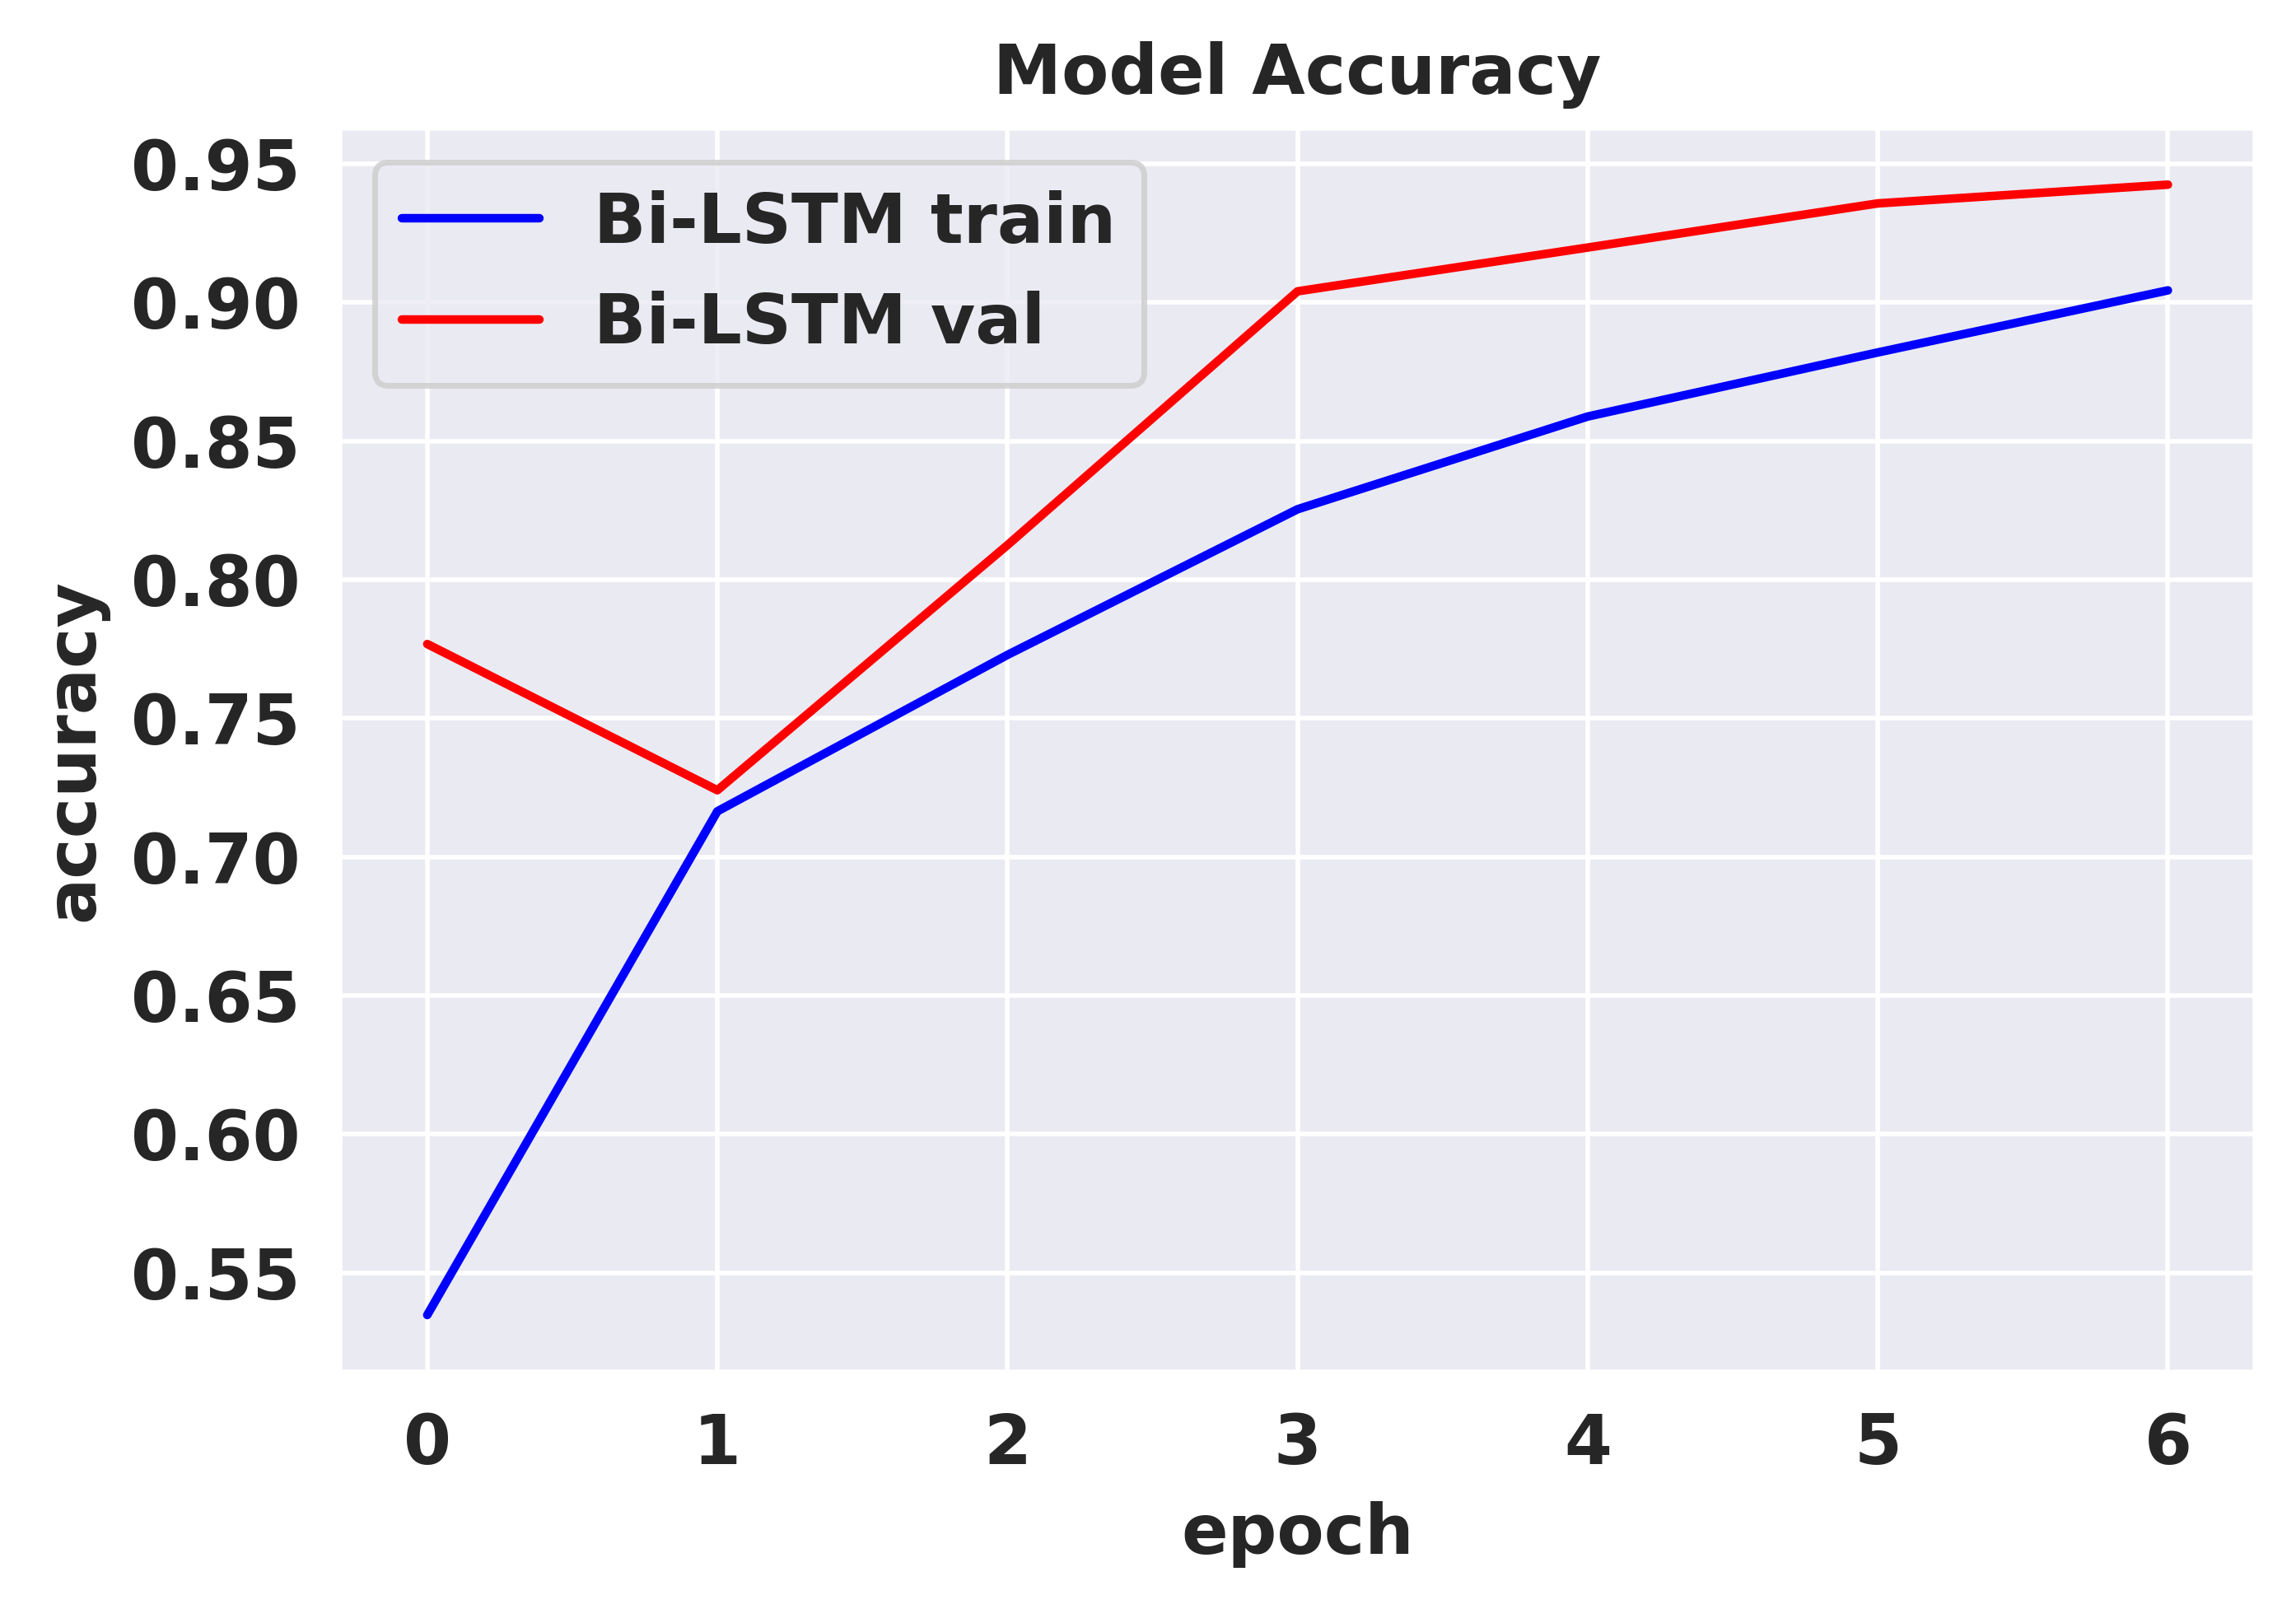

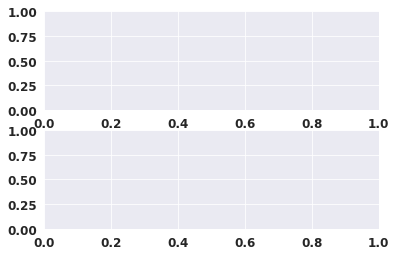

In [75]:
from pylab import mpl
import seaborn as sns
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(facecolor='snow')
sns.set_style("darkgrid", {"font.sans-serif": ['simhei', 'Droid Sans Fallback','Times New Roman']})
font_size = 12
font_family = "SimHei"
font_weight = "bold"
plt.rc("font", size=font_size, family=font_family, weight=font_weight)
font2 = {'family' : 'Times New Roman',
'weight' : 'bold',
'size'   : 12,
}
# figsize=(6.4,4.8),
fig,ax=plt.subplots( dpi=500)
 
val_accuracy=history.history['val_accuracy'][-1]
accuracy=history.history['accuracy'][-1]
print("accuary:{}".format(max(val_accuracy,accuracy)))
s, (one, two) = plt.subplots(2, 1)
ax.plot(history.history['accuracy'], c='b')
ax.plot(history.history['val_accuracy'], c='r')
ax.set_title('Model Accuracy',font2)
ax.set_ylabel("accuracy" ,font2)
ax.set_xlabel("epoch" ,font2)
ax.legend(['Bi-LSTM train', 'Bi-LSTM val'], loc='upper left')

# ax.plot(history.history['loss'], c='m')
# ax.plot(history.history['val_loss'], c='c')
# ax.set_title('Model Loss', font2)
# ax.set_ylabel('loss', font2)
# ax.set_xlabel('epoch', font2)
# ax.legend(['train', 'val'], loc='upper left')

In [51]:
# 模型的输出概率在 0 - 1 之间，这里我们设定一个阈值： 0.5， 如果概率 > 0.5，则会 正面，否则，为负面评论
def Judge(score):
    return 1 if score > 0.5 else 0

In [52]:
# 模型在test上预测
scores = model.predict(x_test, verbose=1, batch_size=10000)

3/3 [==============================] - 1s 304ms/step


In [53]:
# 最终的预测结果
y_pred = [Judge(score) for score in scores]
# y_pred

In [54]:
y_test.squeeze()

array([0, 1, 0, ..., 0, 0, 0])

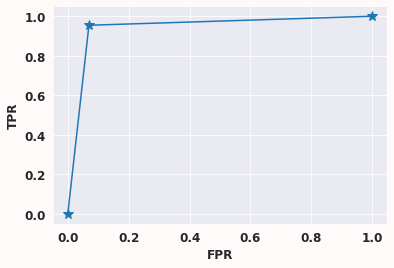

In [71]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from pylab import mpl
import seaborn as sns
mpl.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False
plt.figure(facecolor='snow')
sns.set_style("darkgrid", {"font.sans-serif": ['simhei', 'Droid Sans Fallback','Times New Roman']})
font_size = 12
font_family = "SimHei"
font_weight = "bold"
plt.rc("font", size=font_size, family=font_family, weight=font_weight)
font2 = {'family' : 'Times New Roman',
'weight' : 'bold',
'size'   : 12,
}
# fig,ax=plt.subplots(figsize=(6.4,4.8), dpi=500)
fpr, tpr, t = roc_curve(y_test, y_pred)
x = fpr
plt.plot(x,tpr, label='AUC', linestyle='-', marker='*',  markersize='10')
plt.xlabel('FPR', font2)
plt.ylabel('TPR', font2)
plt.tick_params(axis='both', labelsize=12)
# plt.yaxis.grid(False, linestyle='-.')
legend = ax.legend(loc='best')
plt.show()
# import plotly.offline as py
# py.init_notebook_mode(connected=True)
# import plotly.graph_objs as go
# import plotly.subplots as tls
# import plotly.figure_factory as ff


# def plot_ROC_AUC(y_test, y_pred):
#     fpr, tpr, t = roc_curve(y_test, y_pred)
#     model_roc_auc = roc_auc_score(y_test, y_pred) # 得分
#     trace = go.Scatter(x = fpr, y = tpr,
#                        name = "ROC : " + str(model_roc_auc),
#                        line = dict(color=('rgb(22, 96, 167)'), width = 4), fill = 'tozeroy')
#     fig = tls.make_subplots(rows=1, cols=1, print_grid=False)
#     fig.append_trace(trace,1,1)
#     fig.layout.xaxis.update(dict(title="FPR"), range=[0, 1.05])
#     fig.layout.yaxis.update(dict(title="TPR",range=[0, 1.05]))
#     fig.layout.titlefont.size = 18 # 标题字体大小
#     # fig.layout.yaxis.tickfont.size = 15　#改变tick字体大小

#     py.iplot(fig)
    
# plot_ROC_AUC(y_test.squeeze(), y_pred)

### 模型性能评估

In [72]:
# 模型性能评估
from sklearn.metrics import confusion_matrix
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.subplots as tls
import plotly.figure_factory as ff

def show_matrics(y_test, y_pred):
    # 计算混淆矩阵
    conf_matrix = confusion_matrix(y_test, y_pred)
    trace1 = go.Heatmap(z = conf_matrix, x = ["0(pred)", "1(pred)"],
                       y = ["0(True)", "1(True)"], xgap = 2, ygap = 2,
                       colorscale = 'Viridis', showscale = False)
    # 根据混淆矩阵，获取对应的参数值
    TP = conf_matrix[1, 1]
    FN = conf_matrix[1, 0]
    FP = conf_matrix[0, 1]
    TN = conf_matrix[0, 0]
    
    # 计算accuracy, precision, recall, f1_score
    accuracy = (TP + TN) / (TP + TN + FP + FN) # 准确率
    precision = TP / (TP + FP) # 精准率
    recall = TP / (TP + FN) # 召回率
    F1_score = 2 * precision * recall / (precision + recall)
    
    # 显示以上四个指标
    show_metrics = pd.DataFrame(data = [[accuracy, precision, recall, F1_score]])
    show_metrics = show_metrics.T
    
    # 可视化显示
    colors = ['gold', 'lightgreen', 'lightcoral', 'lightskyblue']
    trace2 = go.Bar(x = show_metrics[0].values,
                    y = ['Accuracy', 'Precision', 'Recall', 'F1_score'],
                    text = np.round_(show_metrics[0].values, 4),
                    textposition = 'auto',
                    orientation = 'h',
                    opacity = 0.8,
                    marker = dict(color = colors, line = dict(color="#000000", width=1.5)))
    
    fig = tls.make_subplots(rows=2, cols=1, subplot_titles=('Confusion Matrix', 'Metrics'))
    fig.append_trace(trace1, 1, 1)
    fig.append_trace(trace2, 2, 1)
    py.iplot(fig)


show_matrics(y_test.squeeze(), y_pred)